# Experimento com dados de todos os poços

Nesse notebook será realizado as tarefas de obtenção de dados, tratamento, modelagem, e validação de dados.
O objetivo aqui é obter um classificador de anomalias para dados de todos os poços (aqui será incluido todos os tipos de dados: inclusive dados de fontes simulação e desenhados).

# Aquisição de dados

Configurando ambiente: 

In [1]:
import sys
sys.path.append("..")

# Environment configuration
import raw_data_manager.raw_data_acquisition as rda
import raw_data_manager.raw_data_inspector as rdi
import raw_data_manager.raw_data_splitter as rds
from data_exploration.metric_acquisition import MetricAcquisition
from data_preparation.transformation_manager import TransformationManager
from constants import storage_config
import pathlib
import numpy as np
import random
import pickle

# Set default logging level.
from absl import logging
logging.set_verbosity(logging.DEBUG)

/home/ubuntu/lemi_3w/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Baixar dataset 3W (se não disponível) & gerar tabela de metadados.

In [2]:
## Acquire data (of entire 3W dataset)
rda.acquire_dataset_if_needed()
latest_converted_data_path, latest_converted_data_version = (
    rda.get_latest_local_converted_data_version(storage_config.DIR_PROJECT_DATA)
)

# Helper to overview metadata (of entire 3W dataset)
inspector_all_data = rdi.RawDataInspector(
    dataset_dir=latest_converted_data_path,
    cache_file_path=storage_config.PATH_DATA_INSPECTOR_CACHE,
    use_cached=True
)
metadata_all_data = inspector_all_data.get_metadata_table()
metadata_all_data

INFO:absl:Directory with the biggest version: /home/ubuntu/lemi_3w/data/dataset_converted_v10101
INFO:absl:Version: 10101
INFO:absl:Latest local version is 10101
INFO:absl:Going to fetch config file from $https://raw.githubusercontent.com/petrobras/3W/main/dataset/dataset.ini
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2786  100  2786    0     0   4038      0 --:--:-- --:--:-- --:--:--  4043
INFO:absl:Latest online version is 10101
INFO:absl:Found existing converted data with dataset version of 10101
INFO:absl:Directory with the biggest version: /home/ubuntu/lemi_3w/data/dataset_converted_v10101
INFO:absl:Version: 10101


,class_type,source,well_id,path,timestamp,file_size,num_timesteps
hash_id,,,,,,,
74203bb,NORMAL,REAL,1.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-05-24 03:00:00,491415,17885
9fbd6f9,NORMAL,REAL,2.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-09 06:00:00,520154,17933
28804c5,NORMAL,REAL,6.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-05-08 09:00:31,349162,17970
42afe91,NORMAL,REAL,8.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-07-01 14:01:35,251880,17799
fa71d94,NORMAL,REAL,6.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-23 19:00:00,279737,17949
...,...,...,...,...,...,...,...
ea66cf6,SEVERE_SLUGGING,SIMULATED,NaN,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,NaT,2315903,61999
34f032a,SEVERE_SLUGGING,SIMULATED,NaN,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,NaT,2259539,61999
876a969,SEVERE_SLUGGING,REAL,14.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-09-25 06:00:42,1005717,17959


Dividir dados (de forma estratificada) em treinamento e teste.

In [3]:
# splits data, from the selected well, into train and test datasets
splitter = rds.RawDataSplitter(metadata_all_data, latest_converted_data_version)
split_train_dir, split_validation_dir, split_test_dir = splitter.stratefy_split_of_data(
    data_dir=storage_config.DIR_PROJECT_DATA, 
    validation_size=0.10,
    test_size=0.20,
)

DEBUG:absl:validation_size 0.1
DEBUG:absl:size of train data: 1384. val: 198. test: 396
DEBUG:absl:train path /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-all_train -/- val: /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-all_validation -/- test: /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-all_test
DONE: 100%|██████████| 198/198 [00:00<00:00, 673.37it/s]


In [4]:
# generates metadata tables for split data
train_metadata = rdi.RawDataInspector(
    dataset_dir=split_train_dir,
    cache_file_path=storage_config.DIR_PROJECT_CACHE / "train_metadata_all_data.parquet",
    use_cached=False,
)
validation_metadata = rdi.RawDataInspector(
    dataset_dir=split_validation_dir,
    cache_file_path=storage_config.DIR_PROJECT_CACHE / "validation_metadata_all_data.parquet",
    use_cached=False,
)
test_metadata = rdi.RawDataInspector(
    dataset_dir=split_test_dir,
    cache_file_path=storage_config.DIR_PROJECT_CACHE / "test_metadata_all_data.parquet",
    use_cached=False,
)

INFO:absl:Processing 416 events of class type 0.
DONE: 100%|██████████| 241/241 [00:00<00:00, 352.11it/s]INFO:absl:Processing 315 events of class type 5.

DONE: 100%|██████████| 315/315 [00:02<00:00, 154.92it/s]INFO:absl:Processing 90 events of class type 1.

DONE: 100%|██████████| 90/90 [00:01<00:00, 53.83it/s]
INFO:absl:Processing 10 events of class type 7.
DONE: 100%|██████████| 10/10 [00:00<00:00, 13.25it/s]
INFO:absl:Processing 154 events of class type 6.
DONE: 100%|██████████| 154/154 [00:01<00:00, 148.18it/s]INFO:absl:Processing 57 events of class type 8.

DONE: 100%|██████████| 27/27 [00:00<00:00, 104.42it/s]INFO:absl:Processing 74 events of class type 3.

DONE: 100%|██████████| 74/74 [00:00<00:00, 88.02it/s] 
INFO:absl:Processing 59 events of class type 0.
DONE: 100%|██████████| 59/59 [00:00<00:00, 136.83it/s]
INFO:absl:Processing 34 events of class type 4.
DONE: 100%|██████████| 34/34 [00:00<00:00, 164.58it/s]
INFO:absl:Processing 45 events of class type 5.
DONE: 100%|███████

Tabela de anomalias por tipo de fonte - treinamento.

In [5]:
rdi.RawDataInspector.generate_table_by_anomaly_source(train_metadata.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,416,0,0,416
ABRUPT_INCREASE_BSW,3,80,7,90
SPURIOUS_CLOSURE_DHSV,16,11,0,27
SEVERE_SLUGGING,22,52,0,74
FLOW_INSTABILITY,241,0,0,241
RAPID_PRODUCTIVITY_LOSS,8,307,0,315
QUICK_RESTRICTION_PCK,4,150,0,154
SCALING_IN_PCK,3,0,7,10
HYDRATE_IN_PRODUCTION_LINE,0,57,0,57


Tabela de anomalias por tipo de fonte - validação.

In [6]:
rdi.RawDataInspector.generate_table_by_anomaly_source(validation_metadata.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,59,0,0,59
ABRUPT_INCREASE_BSW,1,11,1,13
SPURIOUS_CLOSURE_DHSV,2,2,0,4
SEVERE_SLUGGING,3,7,0,10
FLOW_INSTABILITY,34,0,0,34
RAPID_PRODUCTIVITY_LOSS,1,44,0,45
QUICK_RESTRICTION_PCK,1,22,0,23
SCALING_IN_PCK,1,0,1,2
HYDRATE_IN_PRODUCTION_LINE,0,8,0,8


Tabela de anomalias por tipo de fonte - teste.

In [7]:
rdi.RawDataInspector.generate_table_by_anomaly_source(test_metadata.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,119,0,0,119
ABRUPT_INCREASE_BSW,1,23,2,26
SPURIOUS_CLOSURE_DHSV,4,3,0,7
SEVERE_SLUGGING,7,15,0,22
FLOW_INSTABILITY,69,0,0,69
RAPID_PRODUCTIVITY_LOSS,2,88,0,90
QUICK_RESTRICTION_PCK,1,43,0,44
SCALING_IN_PCK,1,0,2,3
HYDRATE_IN_PRODUCTION_LINE,0,16,0,16


# Procesamento de dados

Remoção de valores extremos.

In [8]:
from parallelbar import progress_map

def is_event_path_values_valid(event_path):
    event = rda.get_event(event_path)
    return TransformationManager.is_event_values_valid(event)

valid_index_list = progress_map(is_event_path_values_valid, train_metadata.get_metadata_table()['path'].to_list())

non_valid_ids = [index for index, value in enumerate(valid_index_list) if value == False]
non_valid_ids

DONE: 100%|██████████| 1384/1384 [00:16<00:00, 84.53it/s]


[681, 702, 821, 1054, 1068, 1285, 1290, 1297, 1301]

In [9]:
valid_train_metadata = train_metadata.get_metadata_table().copy()
print("stating size is:", len(valid_train_metadata))

valid_train_metadata.drop(valid_train_metadata.index[non_valid_ids], inplace=True, axis='index')
print("final size is:", len(valid_train_metadata))

stating size is: 1384
final size is: 1375


Calcular valores da média dos valores e do desvio padrão.

In [10]:
from data_exploration.metric_acquisition import MetricAcquisition

cache_file_name = "all_data_metrics"

metric_aquisition = MetricAcquisition(valid_train_metadata)
mean_and_std_metric_table = metric_aquisition.get_mean_and_std_metric(
    cache_file_name=cache_file_name,
    use_cache=False
)

mean_metric_list = mean_and_std_metric_table['mean_of_means']
std_metric_list = mean_and_std_metric_table['mean_of_stds']
mean_and_std_metric_table

DONE: 100%|██████████| 1375/1375 [00:07<00:00, 187.10it/s]
DEBUG:absl:Mean of means was adquired
             P-PDG         P-TPT       T-TPT     P-MON-CKP   T-JUS-CKP  \
0     0.000000e+00  8.715824e+06  117.581821  1.539264e+06   77.332955   
1     4.203851e+07  1.806945e+07  118.569073  2.492268e+06   79.545939   
2     4.485805e+07  2.114707e+07  116.569785  1.224582e+07   61.885166   
3     0.000000e+00  2.078830e+07  106.345925  1.150086e+07   67.224899   
4     0.000000e+00  7.431188e+06  115.475035  1.654020e+06   68.952580   
...            ...           ...         ...           ...         ...   
1370  2.424625e+07  1.511253e+07   44.579236  2.051035e+06   26.684643   
1371  1.539201e+07  8.925425e+06  120.387588  4.042629e+06   94.437207   
1372  2.077121e+07  1.138257e+07  119.183729  4.102729e+06   88.286792   
1373  1.660494e+07  9.154420e+06  122.202564  4.044520e+06  101.257945   
1374  1.898863e+07  1.076657e+07  116.316665  4.090173e+06   78.424427   

        P-JUS-

,mean_of_means,mean_of_stds
P-PDG,1.647858e+07,1.203992e+07
P-TPT,1.517916e+07,3.679432e+06
T-TPT,1.061071e+02,1.639070e+01
P-MON-CKP,4.741109e+06,3.069288e+06
T-JUS-CKP,7.889183e+01,1.881297e+01
P-JUS-CKGL,3.574706e+08,2.496955e+08
QGL,2.570021e-01,1.625997e-01


Realizar a transformação dos dados.

In [11]:
selected_variables = ["P-PDG", "P-TPT", "T-TPT", "P-MON-CKP", 
                      "T-JUS-CKP", "P-JUS-CKGL", "class"]
transformation_param_sample_interval_seconds=60
transformation_param_num_timesteps_for_window=20

Transformar conjunto de dados para treinamento.

In [12]:
train_tranformed_folder_name = split_train_dir.name

train_transformation_manager = TransformationManager(
    valid_train_metadata, 
    output_folder_base_name=train_tranformed_folder_name
)

train_transformation_manager.apply_transformations_to_table(
    output_parent_dir=storage_config.DIR_PROJECT_DATA,
    selected_variables=selected_variables,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

DEBUG:absl:TransformationManager initialized with 1375 items.
            Folder name is dataset_converted_v10101_split-20_source-all_class-all_well-all_train.
DONE: 100%|██████████| 1375/1375 [00:23<00:00, 57.73it/s]


Transformar conjunto de dados para validação.

In [13]:
validation_tranformed_folder_name = split_validation_dir.name

validation_transformation_manager = TransformationManager(
    validation_metadata.get_metadata_table(), 
    output_folder_base_name=validation_tranformed_folder_name
)

validation_transformation_manager.apply_transformations_to_table(
    output_parent_dir=storage_config.DIR_PROJECT_DATA,
    selected_variables=selected_variables,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

DEBUG:absl:TransformationManager initialized with 198 items.
            Folder name is dataset_converted_v10101_split-20_source-all_class-all_well-all_validation.
DONE: 100%|██████████| 198/198 [00:03<00:00, 52.55it/s]


Transformar conjunto de dados para testagem.

In [14]:
test_tranformed_folder_name = split_test_dir.name

test_transformation_manager = TransformationManager(
    test_metadata.get_metadata_table(),
    output_folder_base_name=test_tranformed_folder_name
)

test_transformation_manager.apply_transformations_to_table(
    output_parent_dir=storage_config.DIR_PROJECT_DATA,
    selected_variables=selected_variables,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

DEBUG:absl:TransformationManager initialized with 396 items.
            Folder name is dataset_converted_v10101_split-20_source-all_class-all_well-all_test.
DONE: 100%|██████████| 396/396 [00:07<00:00, 52.11it/s]


# Verificação dos dados

Garantir que os dados processados estão dentro das especificações esperadas.

Obter lista dos arquivos a serem usados no treinamento, validação e testagem.

In [15]:
# Get transformed files paths
TRANSFORMATION_NAME_PREFIX = "transform-isdt-"
train_tranformed_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + train_tranformed_folder_name)
validation_tranformed_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + validation_tranformed_folder_name)
test_tranformed_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + test_tranformed_folder_name)

# Generate inspectors for the transformed data
train_inspector_converted = rdi.RawDataInspector(
    train_tranformed_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "all_wells_transformed-train.parquet",
    use_cached=False
)
validation_inspector_transformed = rdi.RawDataInspector(
    validation_tranformed_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "all_wells_transformed-validation.parquet",
    use_cached=False
)
test_inspector_transformed = rdi.RawDataInspector(
    test_tranformed_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "all_wells_transformed-test.parquet",
    use_cached=False
)

# Get list of paths for the events in each of the data groups (train, val, test)
train_metadata_converted = train_inspector_converted.get_metadata_table()
train_transformed_file_path_list = train_metadata_converted["path"].to_list()

validation_metadata_transformed = validation_inspector_transformed.get_metadata_table()
validation_transformed_file_path_list = validation_metadata_transformed["path"].to_list()

test_metadata_transformed = test_inspector_transformed.get_metadata_table()
test_transformed_file_path_list = test_metadata_transformed["path"].to_list()

# shuffle
random.shuffle(train_transformed_file_path_list)
random.shuffle(validation_transformed_file_path_list)
random.shuffle(test_transformed_file_path_list)

INFO:absl:Processing 416 events of class type 0.
DONE: 100%|██████████| 416/416 [00:00<00:00, 2786.70it/s]
INFO:absl:Processing 241 events of class type 4.
DONE: 100%|██████████| 241/241 [00:00<00:00, 1850.80it/s]
INFO:absl:Processing 312 events of class type 5.
DONE: 100%|██████████| 89/89 [00:00<00:00, 724.90it/s]
INFO:absl:Processing 9 events of class type 7.
DONE: 100%|██████████| 9/9 [00:00<00:00, 101.83it/s]
INFO:absl:Processing 154 events of class type 6.
DONE: 100%|██████████| 154/154 [00:00<00:00, 1005.11it/s]INFO:absl:Processing 57 events of class type 8.

DONE: 100%|██████████| 74/74 [00:00<00:00, 604.45it/s]
INFO:absl:Processing 59 events of class type 0.
DONE: 100%|██████████| 59/59 [00:00<00:00, 421.18it/s]INFO:absl:Processing 34 events of class type 4.

DONE: 100%|██████████| 34/34 [00:00<00:00, 264.06it/s]INFO:absl:Processing 45 events of class type 5.

DONE: 100%|██████████| 45/45 [00:00<00:00, 308.15it/s]
INFO:absl:Processing 13 events of class type 1.
DONE: 100%|████

Exemplo de um par X, y.

In [16]:
example_transformed_file_path = train_transformed_file_path_list[0]
X_transformed_ex, y_transformed_ex = TransformationManager.retrieve_pair_array(pathlib.Path(example_transformed_file_path))

X_transformed_ex[0], y_transformed_ex[0]

(array([[ 0.41017792, -0.1297211 ,  1.00273057, -1.1193997 ,  0.25282583,
         -1.43162653],
        [ 0.41018363, -0.12970081,  1.00273098, -1.11939882,  0.25279022,
         -1.43162653],
        [ 0.41018898, -0.12968142,  1.00272925, -1.11939808,  0.25275797,
         -1.43162653],
        [ 0.41019401, -0.12966321,  1.00272844, -1.11939742,  0.25272935,
         -1.43162653],
        [ 0.41019873, -0.12964659,  1.00272691, -1.11939671,  0.25270393,
         -1.43162653],
        [ 0.41020324, -0.12963006,  1.00272488, -1.11939592,  0.25268074,
         -1.43162653],
        [ 0.41020752, -0.1296147 ,  1.00272427, -1.11939503,  0.25265843,
         -1.43162653],
        [ 0.41021163, -0.12959989,  1.0027263 , -1.11939406,  0.25263596,
         -1.43162653],
        [ 0.410131  , -0.12963771,  1.00270596, -1.11939309,  0.25261255,
         -1.43162653],
        [ 0.40934244, -0.13053867,  1.00245287, -1.11939215,  0.25258807,
         -1.43162653],
        [ 0.40811333, -0.13247

Verificar valores mínimos e máximos dos dados.

In [17]:
X_min_list = []
X_max_list = []
y_avg = []

for path in train_transformed_file_path_list:
    X, y = TransformationManager.retrieve_pair_array(pathlib.Path(path))
    X_min_list.append(np.min(np.min(X, axis=0), axis=0))
    X_max_list.append(np.max(np.max(X, axis=0), axis=0))
    y_avg.append(np.sum(y, axis=0) / len(y))

X_min_list = np.array(X_min_list)
X_max_list = np.array(X_max_list)
y_avg = np.array(y_avg)

In [18]:
# Regarding minimum values of X
print("Minimum minimum values:\n", X_min_list.min(axis=0))

print("\n\nMinimum average values:\n", X_min_list.mean(axis=0))

print("\n\nMinimum maximum values:\n", X_min_list.max(axis=0))

Minimum minimum values:
 [-10.71080204  -4.12540926  -6.473617    -1.54469333  -4.28256808
  -1.43361965]


Minimum average values:
 [-0.09719078 -0.27618909 -0.99923993 -0.23979083 -0.46219262 -0.77418881]


Minimum maximum values:
 [2.35711471 2.04841386 1.30146381 2.45695393 5.00741041 6.83255803]


In [19]:
# Regarding max values of X
print("Maximum minimum values:\n", X_max_list.min(axis=0))

print("\n\nMaximum average values:\n", X_max_list.mean(axis=0))

print("\n\nMaximum maximum values:\n", X_max_list.max(axis=0))

Maximum minimum values:
 [-1.94074765 -4.12540926 -6.473617   -1.54469333 -4.19348076 -1.43361965]


Maximum average values:
 [ 0.08808272  0.24910569 -0.45527722  0.02975588  0.05582485 -0.7683222 ]


Maximum maximum values:
 [2.35711471 4.71106719 1.31983226 2.70258949 5.00741041 7.0175901 ]


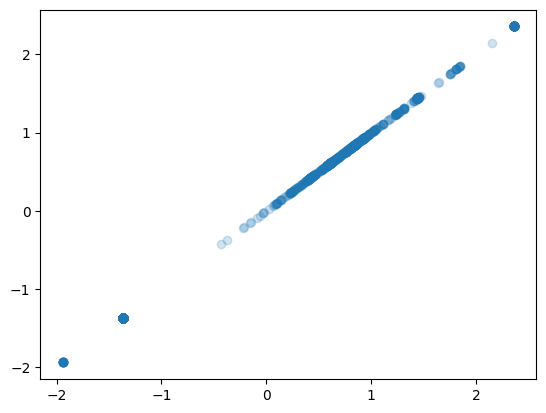

In [20]:
import matplotlib.pyplot as plt

variable_index = 0
plt.scatter(X_max_list[:, variable_index], X_max_list[:, variable_index], alpha=0.2)

In [21]:
np.mean(np.mean(y_avg, axis=0), axis=0)

0.1111111111111111

In [22]:
# Regarding mean values of y
print("Mean y minimum values:\n", y_avg.min(axis=0))

print("\n\nMean y average values:\n", y_avg.mean(axis=0))

print("\n\nMean y maximum values:\n", y_avg.max(axis=0))

Mean y minimum values:
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]


Mean y average values:
 [0.32044563 0.05865368 0.01284887 0.05381818 0.17527273 0.2257795
 0.10753178 0.00525308 0.04039654]


Mean y maximum values:
 [1.         0.98573466 0.95211268 1.         1.         1.
 0.97447796 0.94654088 0.97447796]


In [23]:
y_avg.sum(axis=0)

array([440.61274558,  80.64880342,  17.66719879,  74.        ,
       241.        , 310.44681926, 147.85619858,   7.22299075,
        55.54524362])

# Modelagem

In [24]:
from tensorflow import keras, math
import keras_tuner
from raw_data_manager.models import EventClassType

2023-10-19 23:18:58.739441: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-19 23:18:58.842248: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-19 23:18:59.315602: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-19 23:18:59.315678: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-19 23:18:59.318797: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Using TensorFlow backend


Função responsável por gerar modelos de acordo com uma lista de hyperparâmetros de entrada.

In [25]:
num_features = X_transformed_ex.shape[2]
num_outputs = len(EventClassType)

def build_model(hp: keras_tuner.HyperParameters):
    # model structure
    model = keras.Sequential()

    model.add(keras.layers.LSTM(
        hp.Int('lstm_units', min_value=5, max_value=100, step=5), 
        activation='relu', 
        input_shape=(transformation_param_num_timesteps_for_window, num_features)))
    
    if hp.Boolean("dropout"):
        model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Dense(
        hp.Int('dense_units', min_value=20, max_value=200, step=10),
        activation='relu'))
    
    model.add(keras.layers.Dense(num_outputs, activation='softmax'))

    # compiling model
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
        metrics=['accuracy'],
    )
    return model

# check the model can compile
build_model(keras_tuner.HyperParameters())

In [26]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory=storage_config.DIR_PROJECT_DATA / "keras_tuner",
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 100, 'step': 5, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 10, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


Realizar a pesquisa pelos melhores hyperparâmetros.

In [27]:
num_epochs = 5
steps_per_epoch = len(train_transformed_file_path_list)

train_data_gen = TransformationManager.data_generator_loop(train_transformed_file_path_list)
validation_data_gen = TransformationManager.data_generator_loop(validation_transformed_file_path_list)
test_data_gen = TransformationManager.data_generator_loop(test_transformed_file_path_list)

tuner.search(
    train_data_gen,
    epochs=num_epochs,
    validation_data=validation_data_gen,
    validation_steps=len(validation_transformed_file_path_list),
    steps_per_epoch=steps_per_epoch,
    verbose=1
)

Trial 5 Complete [00h 01m 18s]
val_accuracy: 0.4814925789833069

Best val_accuracy So Far: 0.9362102746963501
Total elapsed time: 00h 11m 34s


In [28]:
# Safe to cache best found parameters
path_best_params = storage_config.DIR_PROJECT_CACHE / "param_search" / "all_data.pkl"
path_best_params.parent.mkdir(parents=True, exist_ok=True)
best_params = tuner.get_best_hyperparameters(5)[0]

with open(path_best_params,'wb') as file:
    pickle.dump(best_params, file)

best_params.values

In [39]:
best_params.values

{'lstm_units': 40,
 'dropout': False,
 'dense_units': 30,
 'lr': 0.0006809543355010622}

Utilizar os parâmetros obtidos que tiveram os melhores resultados para treinar um modelo.

Dessa vez, o modelo será treinado com uma quantidade maior de épocas.

Epoch 1/50
1375/1375 [==============================] - 33s 23ms/step - loss: 1.0391 - accuracy: 0.6873 - val_loss: 0.6312 - val_accuracy: 0.8163
Epoch 2/50
1375/1375 [==============================] - 29s 21ms/step - loss: 0.5380 - accuracy: 0.8372 - val_loss: 0.4322 - val_accuracy: 0.9104
Epoch 3/50
1375/1375 [==============================] - 29s 21ms/step - loss: 0.3729 - accuracy: 0.8760 - val_loss: 0.4199 - val_accuracy: 0.9343
Epoch 4/50
1375/1375 [==============================] - 28s 21ms/step - loss: 0.3470 - accuracy: 0.8915 - val_loss: 0.3737 - val_accuracy: 0.9408
Epoch 5/50
1375/1375 [==============================] - 28s 21ms/step - loss: 0.2889 - accuracy: 0.9076 - val_loss: 0.3426 - val_accuracy: 0.9403
Epoch 6/50
1375/1375 [==============================] - 28s 21ms/step - loss: 0.3053 - accuracy: 0.9129 - val_loss: 0.4798 - val_accuracy: 0.9255
Epoch 7/50
1375/1375 [==============================] - 28s 20ms/step - loss: 0.2575 - accuracy: 0.9272 - val_loss: 0.3824 -

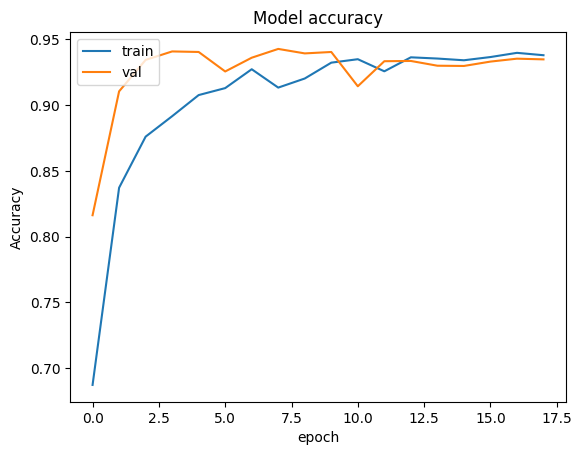

In [29]:
# Training configurations
num_epochs = 50
steps_per_epoch = len(train_transformed_file_path_list)
train_data_gen = TransformationManager.data_generator_loop(train_transformed_file_path_list)
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

checkpoint_filepath = storage_config.DIR_PROJECT_CACHE / "model_weights" / "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_filepath.parent.mkdir(parents=True, exist_ok=True)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Train model
best_model = build_model(best_params)

training_history = best_model.fit(
    train_data_gen, 
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_data_gen,
    validation_steps=len(validation_transformed_file_path_list),
    callbacks=[early_stopping_callback, model_checkpoint_callback],
    verbose=1
)

# Graph of training results history
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Ver se está funcionando com um exemplo.

In [30]:
import numpy as np
test_file = train_transformed_file_path_list[-1]
print(test_file)

Xhat, yhat = TransformationManager.retrieve_pair_array(pathlib.Path(test_file))
print(f"True value: {yhat[0]}")

Xhat0 = Xhat[0].reshape(1, transformation_param_num_timesteps_for_window, num_features)
print(f"Predicted value: {best_model.predict(Xhat0)}")

/home/ubuntu/lemi_3w/data/transform-isdt-dataset_converted_v10101_split-20_source-all_class-all_well-all_train/5/SIMULATED_00309.npz
True value: [0 0 0 0 0 1 0 0 0]
1/1 [==============================] - 0s 236ms/step
Predicted value: [[4.3571442e-02 2.0396810e-04 2.0068900e-03 1.7219167e-03 4.4720280e-03
  8.0223334e-01 1.2927955e-05 1.4973553e-07 1.4577736e-01]]


# Validação
Aqui pegaremos nosso banco de testes, o transformaremos, para então o utilizar para validar a perfomance do nosso modelo.

In [31]:
test_data_gen = TransformationManager.data_generator_non_loop(test_transformed_file_path_list)
num_steps = len(test_transformed_file_path_list)

best_model.evaluate(
    test_data_gen,
    steps=num_steps,
    verbose=1,
)

395/395 [==============================] - 4s 11ms/step - loss: 0.4356 - accuracy: 0.9185


[0.43560388684272766, 0.918455958366394]

In [32]:
test_data_gen = TransformationManager.data_generator_non_loop(test_transformed_file_path_list)

y_test_predictions = best_model.predict(
    test_data_gen,
)

(
    f"Number of predictions: {len(y_test_predictions)}", 
    f"Shape of y array: {y_test_predictions.shape}", 
    y_test_predictions[0]
)

395/395 [==============================] - 4s 10ms/step


('Number of predictions: 162636',
 'Shape of y array: (162636, 9)',
 array([2.6884058e-01, 1.8618914e-05, 8.8015827e-04, 6.7459204e-04,
        1.3789049e-02, 2.5097156e-04, 7.1493304e-01, 1.0168498e-06,
        6.1201805e-04], dtype=float32))

In [33]:
test_data_gen = TransformationManager.data_generator_non_loop(test_transformed_file_path_list)
y_test_labels = []

for X, y in test_data_gen:
    y_test_labels.append(y)

y_test_labels = np.concatenate(y_test_labels, axis=0)

(
    f"Number of predictions: {len(y_test_labels)}", 
    f"Shape of y array: {y_test_labels.shape}", 
    y_test_labels[0],
)

('Number of predictions: 162636',
 'Shape of y array: (162636, 9)',
 array([1, 0, 0, 0, 0, 0, 0, 0, 0]))

In [34]:
y_test_labels_1d = np.argmax(y_test_labels, axis=1)
y_test_predictions_1d = np.argmax(y_test_predictions, axis=1)

math.confusion_matrix(
    y_test_labels_1d,
    y_test_predictions_1d,
    num_classes=num_outputs,
)

<tf.Tensor: shape=(9, 9), dtype=int32, numpy=
array([[31146,  2060,    78,     7,   603,   457,   473,   883,   233],
       [  669, 25849,     0,  1091,     0,     0,     0,  2973,     0],
       [   31,    20,  1379,    25,     0,     2,     3,     0,    14],
       [    0,     0,     0, 13869,   278,  1009,     0,     0,    15],
       [  975,     0,     0,     1,  5981,     0,     0,     0,     0],
       [    3,    13,     0,    87,    20, 41808,     0,     0,     0],
       [   11,     0,     0,     0,     0,     0, 18060,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,  5790,     0],
       [  111,     0,     0,     0,    15,  1102,     0,     0,  5492]],
      dtype=int32)>

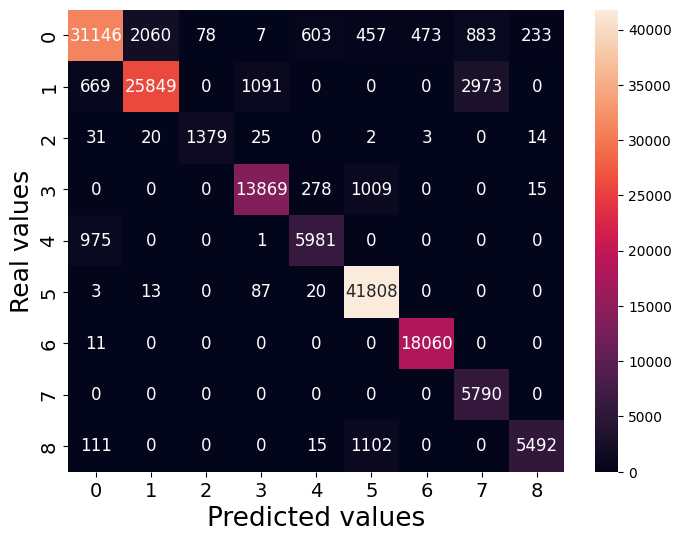

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from raw_data_manager.models import EventClassType

consusion_array = np.array([[31146,  2060,    78,     7,   603,   457,   473,   883,   233],
       [  669, 25849,     0,  1091,     0,     0,     0,  2973,     0],
       [   31,    20,  1379,    25,     0,     2,     3,     0,    14],
       [    0,     0,     0, 13869,   278,  1009,     0,     0,    15],
       [  975,     0,     0,     1,  5981,     0,     0,     0,     0],
       [    3,    13,     0,    87,    20, 41808,     0,     0,     0],
       [   11,     0,     0,     0,     0,     0, 18060,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,  5790,     0],
       [  111,     0,     0,     0,    15,  1102,     0,     0,  5492]],)

fig, ax = plt.subplots(figsize=(8,6))
heatmap = sns.heatmap(consusion_array, annot=True, fmt='d', xticklabels=[e.value for e in EventClassType], yticklabels=[e.value for e in EventClassType], annot_kws={"size": 12})
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 14)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 14)


plt.ylabel('Real values', fontsize=18)
plt.xlabel('Predicted values', fontsize=19)
plt.show()